In [28]:
# Model Parameters

BATCH_SIZE = 4
EDGE_CROP = 16
NB_EPOCHS = 5
GAUSSIAN_NOISE = 0.1
UPSAMPLING_MODE = 'Simple'

NET_SCALING = None

IMG_SCALING = (1, 1)

VALIDATION_SET_SIZE = 400
MAX_TRAIN_STEPS = 200
AUGMENT_BRIGHTNESS = False

In [4]:
import os
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage.io import imread
from skimage.morphology import label
from skimage.util import montage
from skimage.segmentation import mark_boundaries

gc.enable()

In [5]:
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
input_dir = ''

train_image_dir = os.path.join(input_dir, 'train')
test_image_dir = os.path.join(input_dir, 'test')

In [6]:
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T


def multi_rle_encode(img):
    labels = label(img[:, :, 0])
    return [rle_encode(labels == k) for k in np.unique(labels[labels>0])]

def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.int16)
    #if isinstance(in_mask_list, list):
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)

In [7]:
masks = pd.read_csv(os.path.join('train_ship_segmentations.csv'))
print(masks.shape[0], 'mask found')
print(masks['ImageId'].value_counts().shape[0])
masks.head()

(131030, 'mask found')
104070


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
2,00021ddc3.jpg,101361 1 102128 3 102896 4 103663 6 104430 9 1...
3,00021ddc3.jpg,95225 2 95992 5 96760 7 97527 9 98294 9 99062 ...
4,00021ddc3.jpg,74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...


('Check Decoding->Encoding', 'RLE_0:', 9, '->', 'RLE_1:', 4)


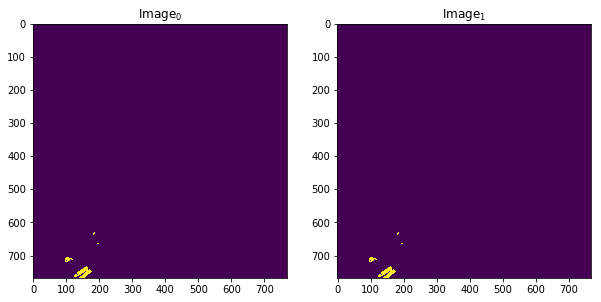

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
rle_0 = masks.query('ImageId=="00021ddc3.jpg"')['EncodedPixels']
img_0 = masks_as_image(rle_0)

ax1.imshow(img_0[:, :, 0])
ax1.set_title('Image$_0$')

rle_1 = multi_rle_encode(img_0)
img_1 = masks_as_image(rle_1)

ax2.imshow(img_1[:, :, 0])
ax2.set_title('Image$_1$')
print('Check Decoding->Encoding',
      'RLE_0:', len(rle_0), '->',
      'RLE_1:', len(rle_1))

,ImageId,ships,has_ship,has_ship_vec,file_size_in_kb
24421,3c13182e2.jpg,1,1.0,[1.0],99
71692,b03351db2.jpg,0,0.0,[0.0],170
84933,d12b09c85.jpg,0,0.0,[0.0],89
72955,b359c672f.jpg,1,1.0,[1.0],130
24723,3ce09a9bd.jpg,3,1.0,[1.0],111


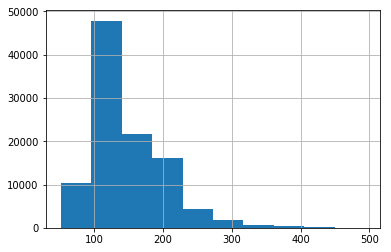

In [9]:
# Spliting into training and validation sets

masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x > 0 else 0.0)
unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])

# some files are too small/corrupt
unique_img_ids['file_size_in_kb'] = unique_img_ids['ImageId'].map(lambda c_img_id: os.stat(os.path.join(train_image_dir, c_img_id)).st_size/1024)
unique_img_ids = unique_img_ids[unique_img_ids['file_size_in_kb']>50]
unique_img_ids['file_size_in_kb'].hist()

masks.drop(['ships'], axis=1, inplace=True)
unique_img_ids.sample(5)

In [10]:
from sklearn.model_selection import train_test_split
train_ids, validation_ids = train_test_split(unique_img_ids, test_size=0.3,
                                            stratify=unique_img_ids['ships'])

train_df = pd.merge(masks, train_ids)
validation_df = pd.merge(masks, validation_ids)

print('Training masks', train_df.shape[0])
print('Validation masks', validation_df.shape[0])

('Training masks', 90956)
('Validation masks', 38983)


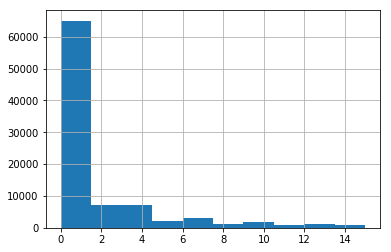

In [11]:
train_df['ships'].hist()

array([ 0,  2,  1,  4,  3,  5,  6,  8,  7,  9, 10, 12, 11, 13, 14, 15])

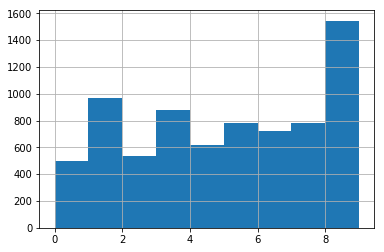

In [12]:
# undersample the data set

def sample_ships(in_df, base_rep=1500):
    if in_df['ships'].values[0] == 0:
        return in_df.sample(base_rep//3)
    else:
        return in_df.sample(base_rep, replace=(in_df.shape[0] < base_rep))

train_df['grouped_ship_count'] = train_df['ships'].map(lambda x: (x + 1)//2).clip(0, 7)

balanced_train_df = train_df.groupby('grouped_ship_count').apply(sample_ships)
balanced_train_df['ships'].hist(bins=np.arange(10))
balanced_train_df.ships.unique()


In [13]:
def make_image_gen(in_df, batch_size=BATCH_SIZE):
    batches = list(in_df.groupby('ImageId'))
    out_rgb = []
    out_mask = []
    
    while True:
        np.random.shuffle(batches)
        for c_img_id, c_masks in batches:
            rgb_path = os.path.join(train_image_dir, c_img_id)
            c_img = imread(rgb_path)
            c_mask = masks_as_image(c_masks['EncodedPixels'].values)
            
            if IMG_SCALING is not None:
                c_img = c_img[::IMG_SCALING[0], ::IMG_SCALING[1]]
                c_mask = c_mask[::IMG_SCALING[0], ::IMG_SCALING[1]]
            
            out_rgb += [c_img]
            out_mask += [c_mask]
            
            if len(out_rgb) >= batch_size:
                yield np.stack(out_rgb, 0)/255.0, np.stack(out_mask, 0)
                out_rgb, out_mask = [], []

In [14]:
train_gen = make_image_gen(balanced_train_df)
train_x, train_y = next(train_gen)
print('x', train_x.shape, train_x.min(), train_x.max())
print('y', train_y.shape, train_y.min(), train_y.max())

('x', (4, 768, 768, 3), 0.0, 1.0)
('y', (4, 768, 768, 1), 0, 1)


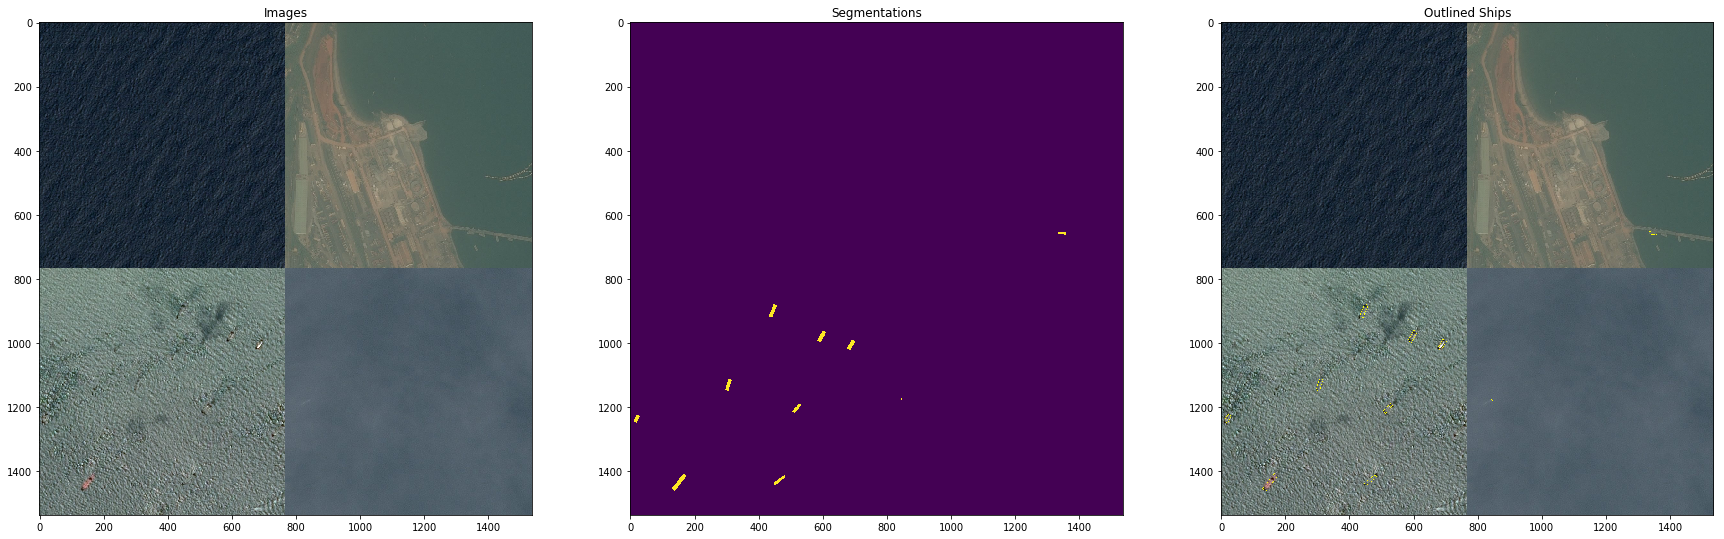

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (30, 10))
batch_rgb = montage_rgb(train_x)
batch_seg = montage(train_y[:, :, :, 0])

ax1.imshow(batch_rgb)
ax1.set_title('Images')

ax2.imshow(batch_seg)
ax2.set_title('Segmentations')

ax3.imshow(mark_boundaries(batch_rgb, batch_seg.astype(int)))
ax3.set_title('Outlined Ships')

fig.savefig('overview.png')

In [16]:
# make validation set

valid_x, valid_y = next(make_image_gen(validation_df, VALIDATION_SET_SIZE))
print(valid_x.shape)
print(valid_y.shape)

(400, 768, 768, 3)
(400, 768, 768, 1)


In [17]:
# Data augmentation

from keras.preprocessing.image import ImageDataGenerator

dg_args = dict(featurewise_center = False,
              samplewise_center = False,
              rotation_range = 15,
              width_shift_range = 0.1,
              height_shift_range = 0.1,
              shear_range = 0.01,
              zoom_range = [0.9, 1.25],
              horizontal_flip = True,
              vertical_flip = True,
              fill_mode = 'reflect',
              data_format = 'channels_last')
# brightness can be problematic since it seems to change the labels differently from the images 
if AUGMENT_BRIGHTNESS:
    dg_args[' brightness_range'] = [0.5, 1.5]
    
image_gen = ImageDataGenerator(**dg_args)

if AUGMENT_BRIGHTNESS:
    dg_args.pop('brightness_range')
    
label_gen = ImageDataGenerator(**dg_args)

def create_aug_gen(in_gen, seed = None):
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    for in_x, in_y in in_gen:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
        g_x = image_gen.flow(255*in_x, batch_size=in_x.shape[0], seed = seed, shuffle = True)
        g_y = image_gen.flow(in_y, batch_size=in_x.shape[0], seed = seed, shuffle = True)
        
        yield next(g_x)/255.0, next(g_y)

('x', (4, 768, 768, 3), dtype('float32'), 0.0, 1.0)
('y', (4, 768, 768, 1), dtype('float32'), 0.0, 1.0)


Text(0.5,1,'ships')

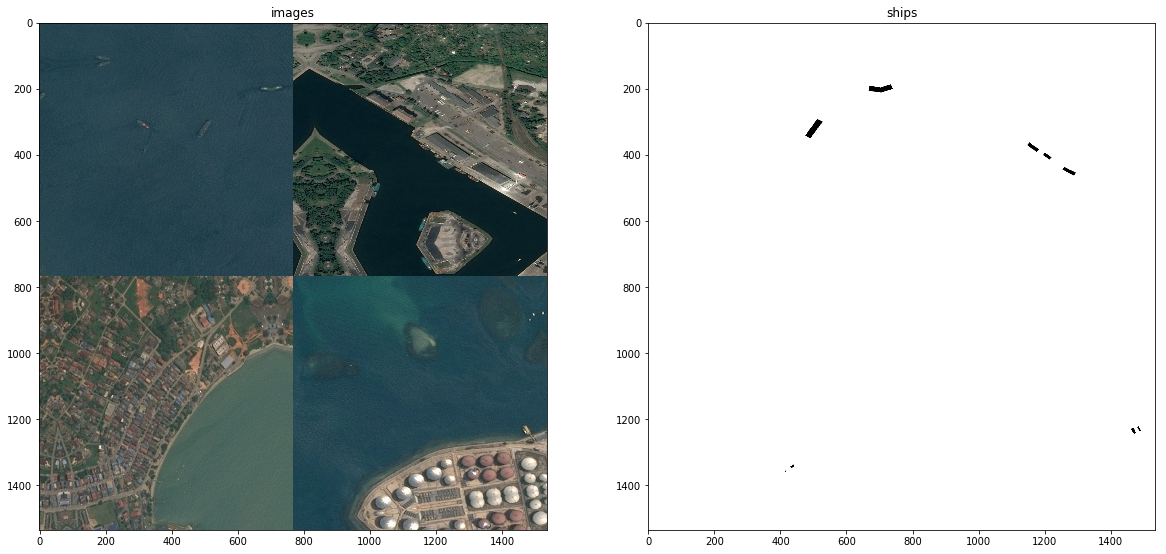

In [20]:
cur_gen = create_aug_gen(train_gen)
t_x, t_y = next(cur_gen)

print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())

t_x = t_x[:9]
t_y = t_y[:9]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))

ax1.imshow(montage_rgb(t_x), cmap='gray')
ax1.set_title('images')

ax2.imshow(montage(t_y[:, :, :, 0]), cmap='gray_r')
ax2.set_title('ships')

In [21]:
gc.collect()

22

In [36]:
# build a model
from keras import models, layers

# Implementing U-Net

def upsample_conv(filters, kernel_size, strides, padding):
    return layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)


def upsample_simple(filters, kernel_size, strides, padding):
    return layers.UpSampling2D(strides)


if UPSAMPLING_MODE == 'DECONV':
    upsample = upsample_conv
else:
    upsample = upsample_simple
    
    
input_img = layers.Input(t_x.shape[1:], name='RGB_Input')
pp_in_layer = input_img


if NET_SCALING is not None:
    pp_in_layer = layers.AvgPool2D(NET_SCALING)(pp_in_layer)

pp_in_layer = layers.GaussianNoise(GAUSSIAN_NOISE)(pp_in_layer)
pp_in_layer = layers.BatchNormalization()(pp_in_layer)

c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(pp_in_layer)
c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(c1)
p1 = layers.MaxPooling2D((2, 2))(c1)

c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(p1)
c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c2)
p2 = layers.MaxPooling2D((2, 2))(c2)

c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(p2)
c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c3)
p3 = layers.MaxPooling2D((2, 2))(c3)

c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p3)
c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c4)
p4 = layers.MaxPooling2D(pool_size=(2, 2))(c4)


c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p4)
c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c5)

u6 = upsample(64, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = layers.concatenate([u6, c4])
c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u6)
c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c6)

u7 = upsample(32, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = layers.concatenate([u7, c3])
c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u7)
c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c7)

u8 = upsample(16, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = layers.concatenate([u8, c2])
c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(u8)
c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c8)

u9 = upsample(8, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = layers.concatenate([u9, c1])
c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(u9)
c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(c9)

d = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
d = layers.Cropping2D((EDGE_CROP, EDGE_CROP))(d)
d = layers.ZeroPadding2D((EDGE_CROP, EDGE_CROP))(d)

if NET_SCALING is not None:
    d = layers.UpSamplling2D(NET_SCALING)(d)

segmentation_model = models.Model(input=[input_img], outputs=[d])
segmentation_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
RGB_Input (InputLayer)          (None, 768, 768, 3)  0                                            
__________________________________________________________________________________________________
gaussian_noise_12 (GaussianNois (None, 768, 768, 3)  0           RGB_Input[0][0]                  
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 768, 768, 3)  12          gaussian_noise_12[0][0]          
__________________________________________________________________________________________________
conv2d_180 (Conv2D)             (None, 768, 768, 8)  224         batch_normalization_12[0][0]     
__________________________________________________________________________________________________
conv2d_181

/Users/ram.ramrakhya/ML/venv/lib/python2.7/site-packages/ipykernel_launcher.py:77: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=[<tf.Tenso...)`
